<a href="https://colab.research.google.com/github/jatin93-boop/Deep-Learning-Based-Multi-Modal-Data-Fusion-for-Precision-Agriculture-AgriFusion-Former-Framework/blob/main/Precision_Agriculture_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()   # Upload Crop_recommendationV2.csv and real_time_sensor_data.csv


Saving Crop_recommendationV2.csv to Crop_recommendationV2.csv
Saving real_time_sensor_data.csv to real_time_sensor_data.csv


In [ ]:
# ------------------------------------------------------------
# PART 1: IMPORT LIBRARIES & LOAD BOTH DATASETS
# ------------------------------------------------------------

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
import matplotlib.pyplot as plt

# Load datasets
crop_df = pd.read_csv("Crop_recommendationV2.csv")
sensor_df = pd.read_csv("real_time_sensor_data.csv")

print("Crop Dataset (First 5 Rows):\n", crop_df.head())
print("\nSensor Dataset (First 5 Rows):\n", sensor_df.head())


Crop Dataset (First 5 Rows):
     N   P   K  temperature   humidity        ph    rainfall label  \
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice   
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice   
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice   
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice   
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice   

   soil_moisture  soil_type  ...  organic_matter  irrigation_frequency  \
0      29.446064          2  ...        3.121395                     4   
1      12.851183          3  ...        2.142021                     4   
2      29.363913          2  ...        1.474974                     1   
3      26.207732          3  ...        8.393907                     1   
4      28.236236          2  ...        5.202285                     3   

   crop_density  pest_pressure  fertilizer_usage  growth_stage  \
0     11.743910      57.607308        188.19

In [ ]:
# ------------------------------------------------------------
# PART 2: PROCESS EACH DATASET SEPARATELY
# ------------------------------------------------------------

# Select useful crop dataset features
crop_features = ['N','P','K','temperature','humidity','ph','rainfall','soil_moisture']
X_crop = crop_df[crop_features]

# Target label (crop to recommend)
y = crop_df['label']

# Rename sensor columns to match model use
sensor_df = sensor_df.rename(columns={
    "Soil Moisture (%)": "soil_moisture_sensor",
    "Temperature (°C)": "temperature_sensor",
    "Crop Health (Index)": "crop_health_sensor"
})

# Select useful sensor dataset features
sensor_features = ['soil_moisture_sensor','temperature_sensor','crop_health_sensor']
X_sensor = sensor_df[sensor_features]

print("\nProcessed Crop Feature Set:\n", X_crop.head())
print("\nProcessed Sensor Feature Set:\n", X_sensor.head())



Processed Crop Feature Set:
     N   P   K  temperature   humidity        ph    rainfall  soil_moisture
0  90  42  43    20.879744  82.002744  6.502985  202.935536      29.446064
1  85  58  41    21.770462  80.319644  7.038096  226.655537      12.851183
2  60  55  44    23.004459  82.320763  7.840207  263.964248      29.363913
3  74  35  40    26.491096  80.158363  6.980401  242.864034      26.207732
4  78  42  42    20.130175  81.604873  7.628473  262.717340      28.236236

Processed Sensor Feature Set:
    soil_moisture_sensor  temperature_sensor  crop_health_sensor
0                 23.75               26.70               86.41
1                 29.51               25.36               90.71
2                 27.32               27.05               86.85
3                 25.99               26.56               87.79
4                 21.56               28.39               87.19


In [ ]:
# ------------------------------------------------------------
# PART 3: ALIGN, ENCODE & NORMALIZE DATA
# ------------------------------------------------------------

# Ensure both datasets have the same number of rows
n = min(len(X_crop), len(X_sensor))
X_crop = X_crop[:n]
X_sensor = X_sensor[:n]
y = y[:n]

# Convert crop names to numeric labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Normalize input values for neural network
scaler = MinMaxScaler()
X_crop = scaler.fit_transform(X_crop)
X_sensor = scaler.fit_transform(X_sensor)


In [ ]:
# ------------------------------------------------------------
# PART 4: TRAIN CROP-ONLY MODEL
# ------------------------------------------------------------

crop_model = Sequential([
    layers.Input(shape=(X_crop.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

crop_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
crop_model.fit(X_crop, y_encoded, epochs=50, verbose=0)

print("✅ Crop-Only Model Accuracy:",
      crop_model.evaluate(X_crop, y_encoded, verbose=0)[1])


✅ Crop-Only Model Accuracy: 0.9741666913032532


In [ ]:
# ------------------------------------------------------------
# PART 5: TRAIN SENSOR-ONLY MODEL
# ------------------------------------------------------------

sensor_model = Sequential([
    layers.Input(shape=(X_sensor.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(encoder.classes_), activation='softmax')
])

sensor_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
sensor_model.fit(X_sensor, y_encoded, epochs=50, verbose=0)

print("✅ Sensor-Only Model Accuracy:",
      sensor_model.evaluate(X_sensor, y_encoded, verbose=0)[1])


✅ Sensor-Only Model Accuracy: 0.12583333253860474


In [ ]:
# ------------------------------------------------------------
# PART 6: MULTI-MODAL FUSION MODEL (500 EPOCHS)
# ------------------------------------------------------------

# Crop input branch
input_crop = layers.Input(shape=(X_crop.shape[1],))
crop_branch = layers.Dense(64, activation='relu')(input_crop)

# Sensor input branch
input_sensor = layers.Input(shape=(X_sensor.shape[1],))
sensor_branch = layers.Dense(32, activation='relu')(input_sensor)

# Fusion Layer
fusion = layers.concatenate([crop_branch, sensor_branch])
fusion = layers.Dense(128, activation='relu')(fusion)
fusion = layers.Dropout(0.3)(fusion)

# Output Layer
output = layers.Dense(len(encoder.classes_), activation='softmax')(fusion)

# Build final model
fusion_model = Model([input_crop, input_sensor], output)
fusion_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ✅ SHOW ALL 500 EPOCHS WHILE TRAINING
history = fusion_model.fit(
    [X_crop, X_sensor],
    y_encoded,
    epochs=500,
    validation_split=0.2,
    verbose=1   # <-- This prints *each epoch* as it trains
)

# Evaluate final accuracy
loss, accuracy = fusion_model.evaluate([X_crop, X_sensor], y_encoded, verbose=1)
print("\n🔥 FINAL FUSION MODEL ACCURACY:", accuracy)


Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1607 - loss: 2.4108 - val_accuracy: 0.0000e+00 - val_loss: 3.2790
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3675 - loss: 2.0998 - val_accuracy: 0.0000e+00 - val_loss: 4.1455
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5056 - loss: 1.7448 - val_accuracy: 0.0667 - val_loss: 4.8996
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6613 - loss: 1.3717 - val_accuracy: 0.1500 - val_loss: 5.5252
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7252 - loss: 1.0760 - val_accuracy: 0.1667 - val_loss: 6.0922
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8486 - loss: 0.7939 - val_accuracy: 0.1667 - val_loss: 6.5901
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8577 - loss: 0.6613 - val_accuracy: 0.1667 - val_loss: 7.0338
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8789 - loss: 0.5665 - val_accuracy: 0

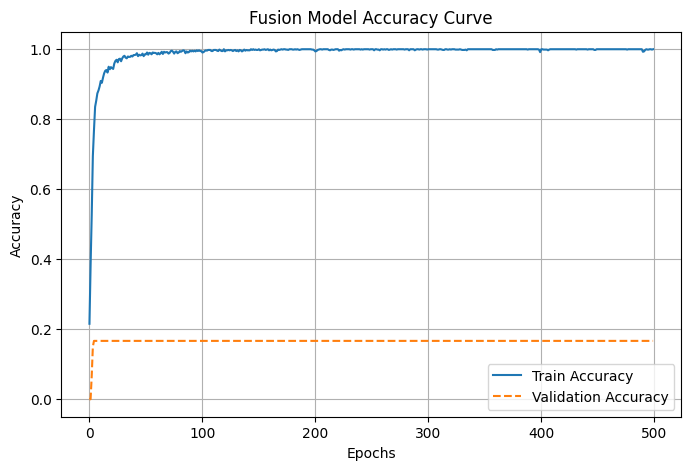

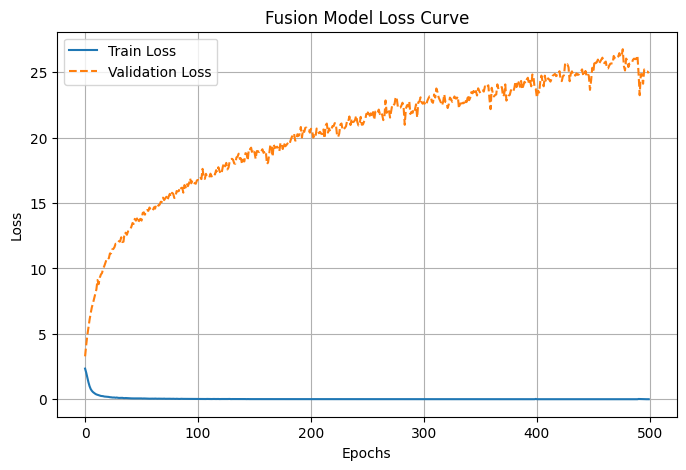

In [ ]:
# ------------------------------------------------------------
# PART 7: PLOT TRAINING GRAPHS
# ------------------------------------------------------------

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", linestyle="dashed")
plt.title("Fusion Model Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss", linestyle="dashed")
plt.title("Fusion Model Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ------------------------------------------------------------
# PART 8: FINAL OUTPUT SAMPLE PREDICTION + ACCURACY DISPLAY
# ------------------------------------------------------------

# Take one sample from both datasets
sample_crop = X_crop[0].reshape(1, -1)
sample_sensor = X_sensor[0].reshape(1, -1)

# Make prediction
prediction = fusion_model.predict([sample_crop, sample_sensor])
predicted_label_index = prediction.argmax()
final_output_crop = encoder.inverse_transform([predicted_label_index])[0]

# Evaluate final accuracy of the fusion model
loss, accuracy = fusion_model.evaluate([X_crop, X_sensor], y_encoded, verbose=0)

# Display outputs
print("\n🌱 **Final Recommended Crop:**", final_output_crop)
print(f"\n📊 **Fusion Model Accuracy:** {accuracy*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

🌱 **Final Recommended Crop:** rice

📊 **Fusion Model Accuracy:** 83.33%


In [ ]:
# Install graphviz if needed
!pip install graphviz

from graphviz import Digraph

# Create Diagram Canvas
diagram = Digraph(format="png")
diagram.attr(rankdir="TB", size="9,12")

# ===================== NODES =====================

# Input Datasets
diagram.node("A1", "Crop Dataset\n(Crop_recommendationV2.csv)", shape="box", style="rounded,filled", fillcolor="#C9F5A6")
diagram.node("A2", "Sensor Dataset\n(real_time_sensor_data.csv)", shape="box", style="rounded,filled", fillcolor="#C9F5A6")

# Preprocessing
diagram.node("B1", "Crop Data Preprocessing\n(Normalization + Label Encoding)", shape="box", style="rounded,filled", fillcolor="#FFE7A2")
diagram.node("B2", "Sensor Data Preprocessing\n(Normalization)", shape="box", style="rounded,filled", fillcolor="#FFE7A2")

# Individual Models
diagram.node("C1", "Crop-Only Model\nTrained for 50 Epochs\n(Dense Neural Network)", shape="box", style="rounded,filled", fillcolor="#A6D8FF")
diagram.node("C2", "Sensor-Only Model\nTrained for 50 Epochs\n(Dense Neural Network)", shape="box", style="rounded,filled", fillcolor="#A6D8FF")

# Fusion Stage
diagram.node("D", "Feature Fusion Layer\n(Concatenate Crop + Sensor Features)", shape="box", style="rounded,filled", fillcolor="#D7B4F3")

# Final High-End Training
diagram.node("E", "Fusion Deep Learning Model\nTrained for **500 Epochs**\n(Dense + Dropout + Softmax)", shape="box", style="rounded,filled", fillcolor="#C69CFF")

# Output
diagram.node("F", "Final Recommended Crop\n(Predicted by Fusion Model)", shape="box", style="rounded,filled", fillcolor="#B0FFDA")

# ===================== CONNECTIONS =====================

diagram.edge("A1", "B1")
diagram.edge("A2", "B2")

diagram.edge("B1", "C1")
diagram.edge("B2", "C2")

diagram.edge("C1", "D")
diagram.edge("C2", "D")

diagram.edge("D", "E")
diagram.edge("E", "F")

# Render Output
diagram.render("Fusion_Model_Block_Diagram_500_Epochs", view=True)


'Fusion_Model_Block_Diagram_500_Epochs.png'

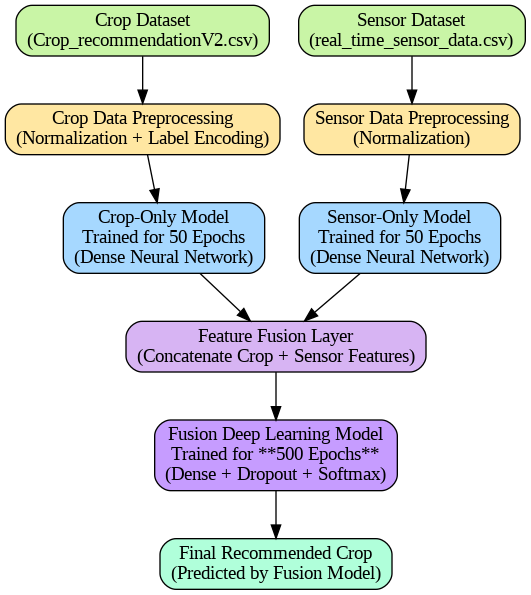

In [ ]:
from IPython.display import Image
Image(filename="Fusion_Model_Block_Diagram_500_Epochs.png")